<img src="https://www3.um.edu.uy/logoum.jpg" width=300>
<h1 align="center">Thesis - KNN Item Item hyperparameter optimization</h1> 
<h2 align="center">Crossfold optimization</h2> 
<h2 align="center">Alejo Paullier</h2> 

In [1]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pylab as pl

%matplotlib inline

ratings = pd.read_csv('C:\\Users\\Alejo\\Tesis\\Demo\\ml-100k\\u.data', sep='\t',
                      names=['user', 'item', 'rating', 'timestamp'])


def eval(aname, algo, train, test):
    fittable = util.clone(algo) # Object cloning means to create an exact copy of the original object.
    fittable = Recommender.adapt(fittable) 
    fittable.fit(train) # Entrenamos el algoritmo con el training dataset
    users = test.user.unique() # Devuelve un array con los users unicos en el testing dataset
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [9]:
metric = []
for partitions in range (1,30):
    all_recs = []
    test_data = []
    algo_ii = knn.ItemItem(12,aggregate='weighted-average')

    for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], partitions, xf.SampleFrac(0.3)):
        test_data.append(test)
        all_recs.append(eval('ItemItem', algo_ii, train, test))

    all_recs = pd.concat(all_recs, ignore_index=True)
    all_recs.head()

    test_data = pd.concat(test_data, ignore_index=True)

    rla = topn.RecListAnalysis()
    rla.add_metric(topn.ndcg)
    results = rla.compute(all_recs, test_data)
    results.head()
    metric.append(results.groupby('Algorithm').ndcg.mean())


In [14]:
metricas_crossfold = pd.DataFrame(metric)

In [16]:
indices = range(1,30)
metricas_crossfold["Indices"]=indices
optimal = metricas_crossfold["ItemItem"].max()
print(optimal)


0.11584893562626947


In [17]:
metricas_crossfold 

Algorithm,ItemItem,Indices
ndcg,0.097536,1
ndcg,0.110155,2
ndcg,0.108927,3
ndcg,0.112043,4
ndcg,0.113106,5
ndcg,0.114185,6
ndcg,0.111552,7
ndcg,0.115542,8
ndcg,0.114025,9
ndcg,0.113914,10


(array([0.095 , 0.0975, 0.1   , 0.1025, 0.105 , 0.1075, 0.11  , 0.1125,
        0.115 , 0.1175]), <a list of 10 Text yticklabel objects>)

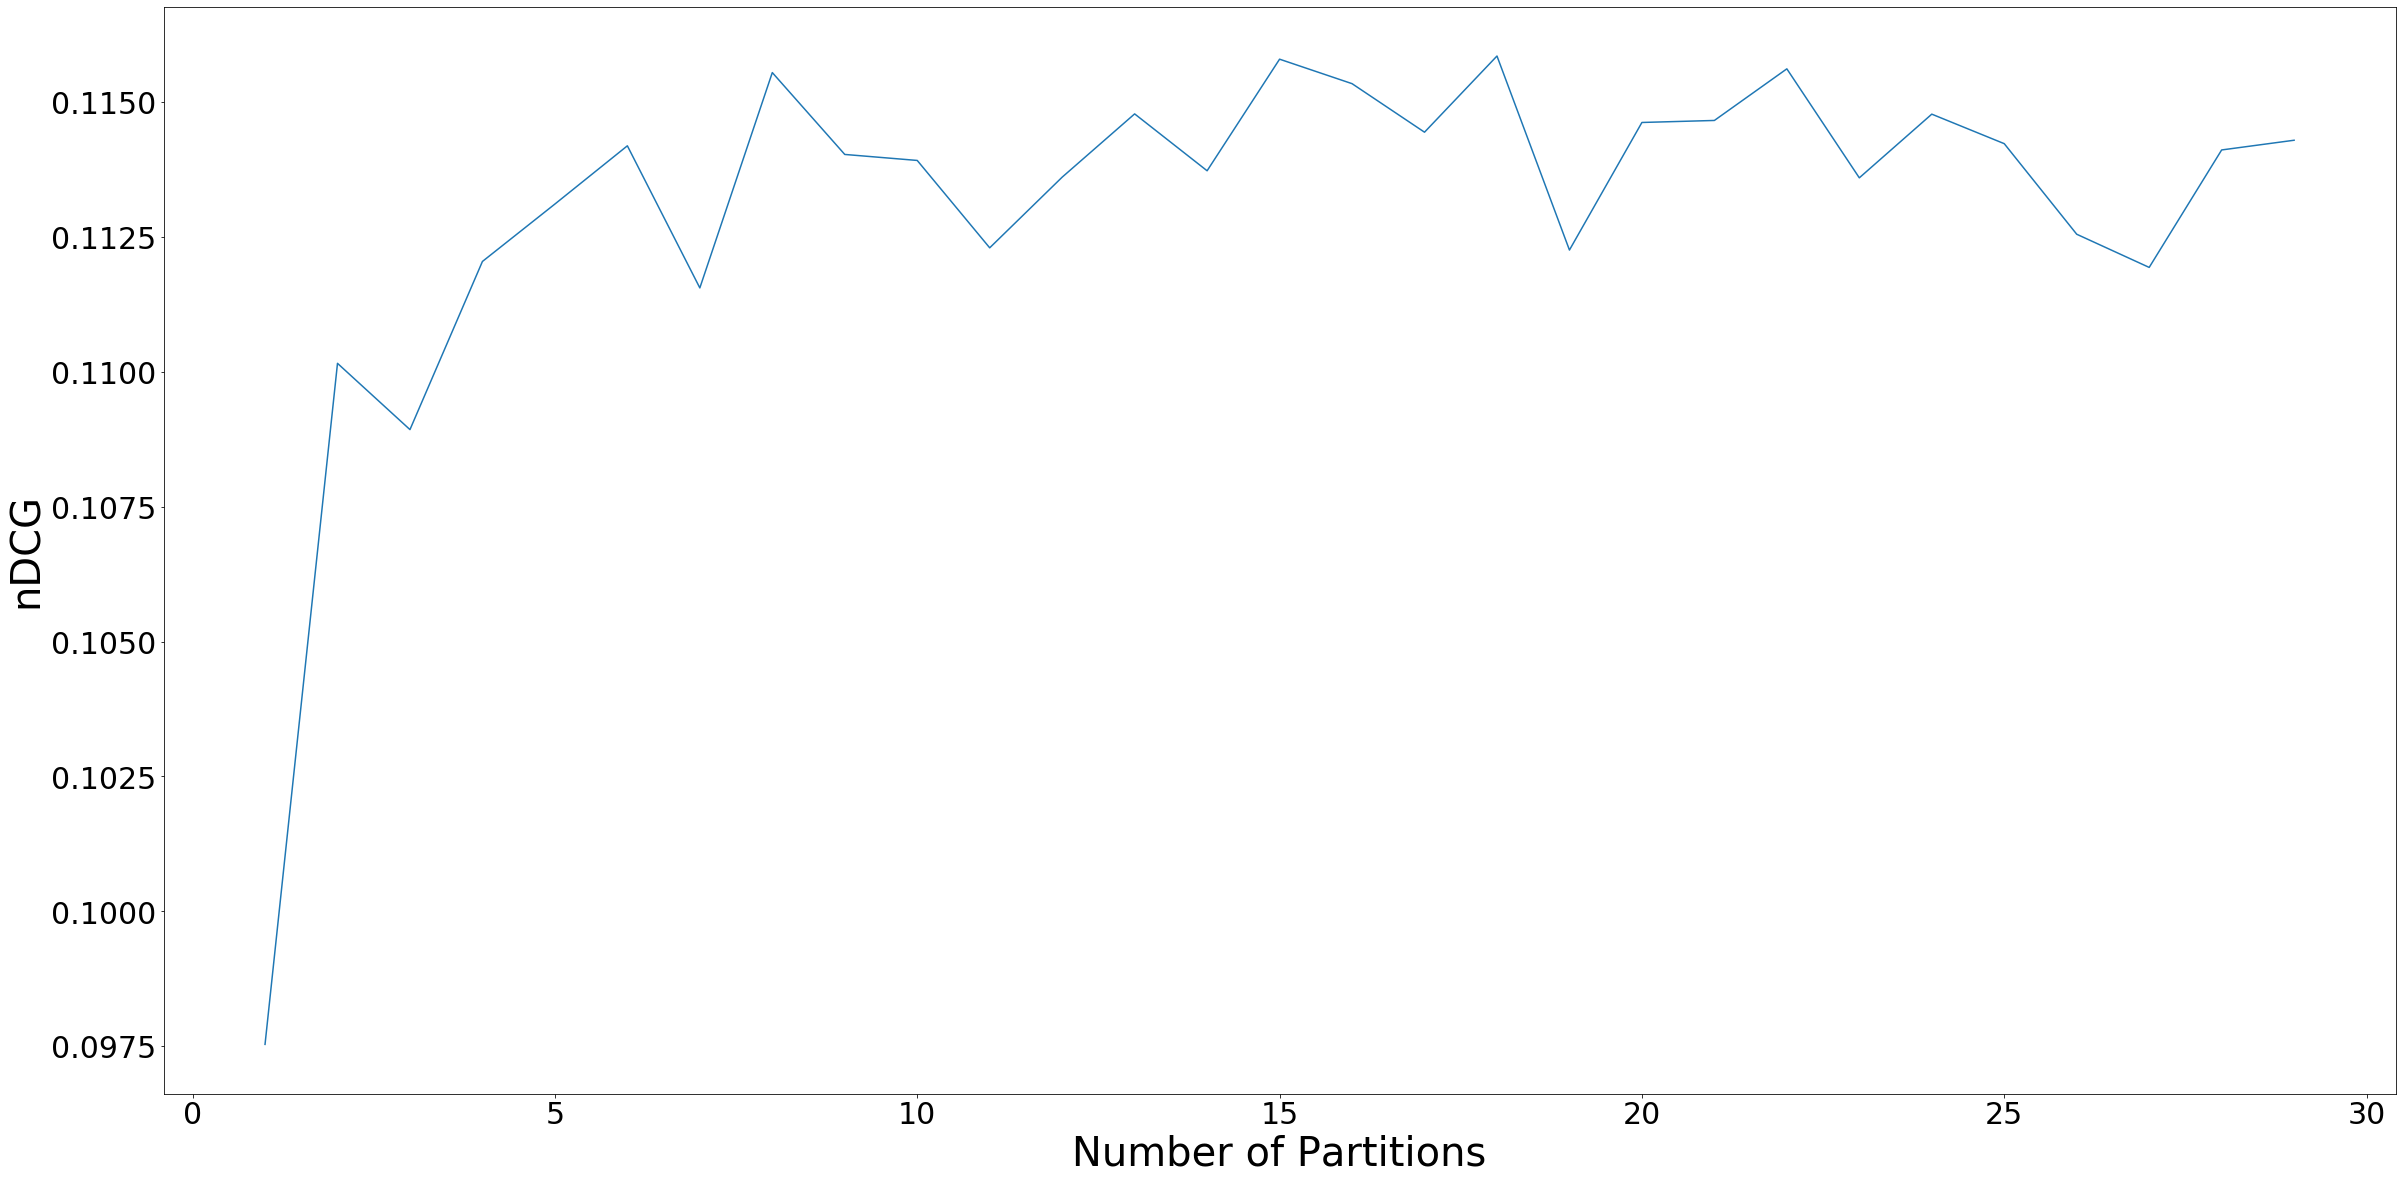

In [13]:
fig, ax = plt.subplots(figsize=(40,20))
chart = sns.lineplot(x="Indices",y="ItemItem",data=metricas_crossfold)
pl.xlabel("Number of Partitions", fontsize=40)
pl.ylabel("nDCG",fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)